In [20]:
%matplotlib inline

import os
import sys

PACKAGE_PARENT = '..'
sys.path.append(PACKAGE_PARENT)

import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from piml.models. import GAMINetRegressor
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
from sklearn.datasets import make_circles
from sklearn.metrics import roc_auc_score
random_state = 0
get_metric = roc_auc_score
x, y = make_circles(n_samples=10000, noise=0.1, random_state=random_state)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)

## Compare with EBM

In [3]:
from interpret.glassbox import ExplainableBoostingRegressor

clf = ExplainableBoostingRegressor(interactions=10, feature_names=["X"+str(i+1) for i in range(train_x.shape[1])])
clf.fit(train_x, train_y)

pred_train = clf.predict(train_x)
pred_test = clf.predict(test_x)
ebm_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(ebm_stat)

[0.92349 0.92592]


In [4]:
from ebm_module.expapi import EBMExplainer
exp = EBMExplainer(clf)
exp.fit(train_x)

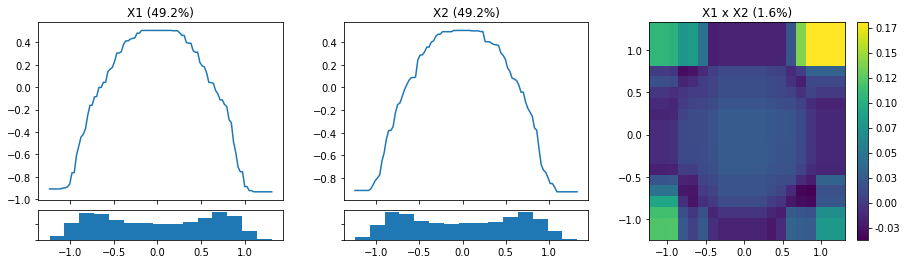

In [5]:
exp.show_global_explain()

## Train GAMI-Net 

In [6]:
model = GAMINetRegressor(interact_num=10,
                         subnet_size_main_effect=(20, ),
                         subnet_size_interaction=(20, 20), 
                         max_epochs=(1000, 1000, 1000),
                         learning_rates=(0.001, 0.001, 0.0001),
                         early_stop_thres=("auto", "auto", "auto"),
                         batch_size=1000,
                         reg_clarity=0.1,
                         loss_threshold=0.01,
                         normalize=True,
                         warm_start=True,
                         verbose=True,
                         random_state=random_state)
model.fit(train_x, train_y)

###############Run Warm Initialization for Main Effect###############
####################Stage 1: Main Effect Training####################


Epoch:    1, train loss: 0.12643, validation loss: 0.12904: 100%|██████████| 7/7 [00:00<00:00, 49.56it/s]                          
Epoch:    2, train loss: 0.12620, validation loss: 0.12898: 100%|██████████| 7/7 [00:00<00:00, 292.61it/s]                         
Epoch:    3, train loss: 0.12562, validation loss: 0.12903: 100%|██████████| 7/7 [00:00<00:00, 297.05it/s]                         
Epoch:    4, train loss: 0.12560, validation loss: 0.12882: 100%|██████████| 7/7 [00:00<00:00, 298.21it/s]                         
Epoch:    5, train loss: 0.12535, validation loss: 0.12861: 100%|██████████| 7/7 [00:00<00:00, 294.37it/s]                         
Epoch:    6, train loss: 0.12518, validation loss: 0.12846: 100%|██████████| 7/7 [00:00<00:00, 301.91it/s]                         
Epoch:    7, train loss: 0.12516, validation loss: 0.12839: 100%|██████████| 7/7 [00:00<00:00, 298.41it/s]                         
Epoch:    8, train loss: 0.12500, validation loss: 0.12838: 100%|██████████|

Main Effect Training Stop at Epoch: 40, train loss: 0.12378, validation loss: 0.12737
###############Run Warm Initialization for Interaction###############
####################Stage 2: Interaction Training####################


Epoch:    1, train loss: 0.11704, validation loss: 0.12275: 100%|██████████| 7/7 [00:00<00:00, 175.69it/s]                         
Epoch:    2, train loss: 0.11631, validation loss: 0.12246: 100%|██████████| 7/7 [00:00<00:00, 186.11it/s]                         
Epoch:    3, train loss: 0.11594, validation loss: 0.12227: 100%|██████████| 7/7 [00:00<00:00, 191.99it/s]                         
Epoch:    4, train loss: 0.11579, validation loss: 0.12206: 100%|██████████| 7/7 [00:00<00:00, 189.43it/s]                         
Epoch:    5, train loss: 0.11545, validation loss: 0.12165: 100%|██████████| 7/7 [00:00<00:00, 143.00it/s]                         
Epoch:    6, train loss: 0.11518, validation loss: 0.12151: 100%|██████████| 7/7 [00:00<00:00, 170.56it/s]                         
Epoch:    7, train loss: 0.11506, validation loss: 0.12131: 100%|██████████| 7/7 [00:00<00:00, 176.15it/s]                         
Epoch:    8, train loss: 0.11469, validation loss: 0.12118: 100%|██████████|

Interaction Training Stop at Epoch: 53, train loss: 0.11114, validation loss: 0.11975
#########################Stage 3: Fine Tuning#########################


Epoch:    1, train loss: 0.11105, validation loss: 0.11972: 100%|██████████| 7/7 [00:00<00:00, 183.65it/s]                         
Epoch:    2, train loss: 0.11100, validation loss: 0.11972: 100%|██████████| 7/7 [00:00<00:00, 183.36it/s]                         
Epoch:    3, train loss: 0.11100, validation loss: 0.11975: 100%|██████████| 7/7 [00:00<00:00, 163.73it/s]                         
Epoch:    4, train loss: 0.11101, validation loss: 0.11973: 100%|██████████| 7/7 [00:00<00:00, 184.20it/s]                         
Epoch:    5, train loss: 0.11103, validation loss: 0.11983: 100%|██████████| 7/7 [00:00<00:00, 174.17it/s]                         
Epoch:    6, train loss: 0.11103, validation loss: 0.11973: 100%|██████████| 7/7 [00:00<00:00, 174.48it/s]                         
Epoch:    7, train loss: 0.11097, validation loss: 0.11973: 100%|██████████| 7/7 [00:00<00:00, 172.22it/s]                         
Epoch:    8, train loss: 0.11095, validation loss: 0.11973: 100%|██████████|

Fine Tuning Stop at Epoch: 8, train loss: 0.11095, validation loss: 0.11973


GAMINetRegressor(batch_size=1000, loss_threshold=0.01, verbose=True)

In [7]:
model.time_cost_

[('fit_interaction', 2.15),
 ('warm_start_interaction', 1.55),
 ('fit_main_effect', 1.27),
 ('warm_start_main_effect', 1.23),
 ('fine_tune_all', 0.34),
 ('add_interaction', 0.02),
 ('get_interaction_list', 0.01),
 ('prune_main_effect', 0.0),
 ('prune_interaction', 0.0)]

In [8]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x) 

gaminet_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                          np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[0.9217  0.92887]


In [9]:
model.get_mono_loss(train_x), model.certify_mono(n_samples=10000)

(0.0, True)

In [10]:
model.get_clarity_loss(test_x)

0.0031420141458511353

## Visualization

### Training details

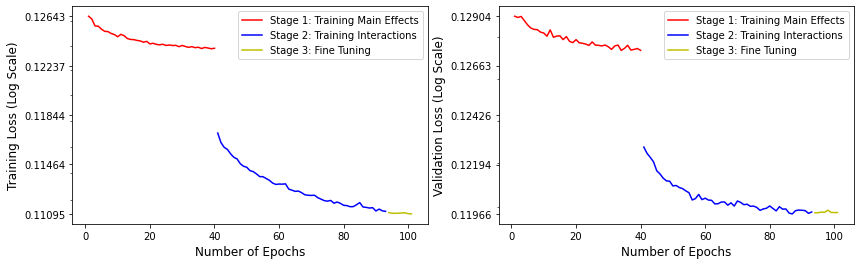

In [11]:
model.show_loss_trajectory()

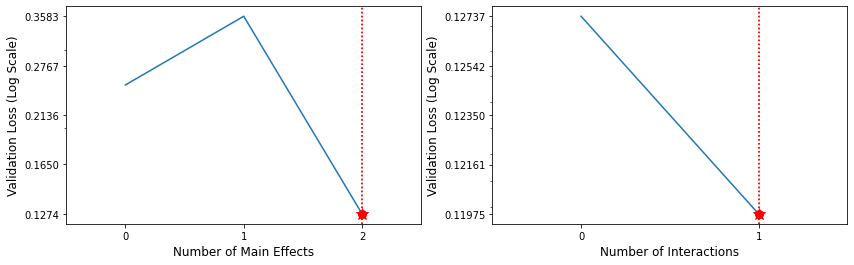

In [12]:
model.show_regularization_path()

### Global explaination

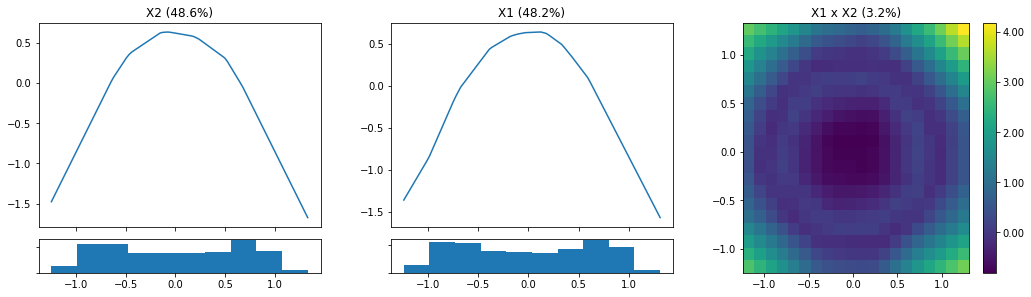

In [13]:
# show all effects 
model.show_global_explain()

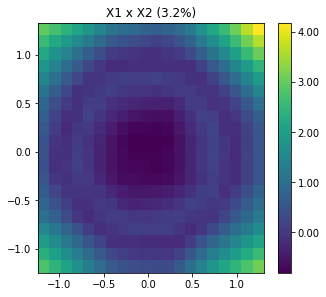

In [16]:
# show one specific effect
model.show_global_explain(key="X1 x X2")

### Feature and effect importance

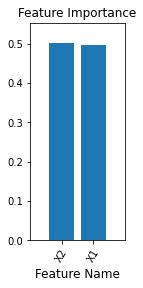

In [17]:
## feature importance 
model.show_feature_importance()

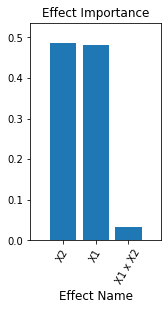

In [18]:
## effect importance 
model.show_effect_importance()

### Local Explain

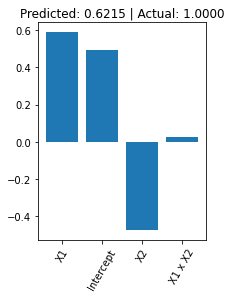

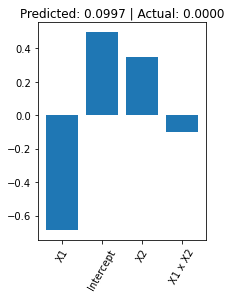

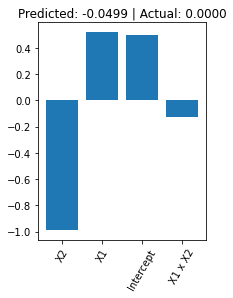

In [19]:
## explain single sample 
model.show_local_explain(train_x[:3], train_y[:3])